<a href="https://colab.research.google.com/github/Abdulrahmann-Omar/Facial-Recognition-Using-Transfer-Learning-with-VGG16-and-ResNet50/blob/main/Assignmet1(1)_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##importing

In [ ]:
import kagglehub
path = kagglehub.dataset_download('apollo2506/facial-recognition-dataset')
print('Data source import complete.')

Data source import complete.


In [ ]:
import keras
train_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/facial-recognition-dataset/Training/Training",
    labels='inferred',
    shuffle=True,
    validation_split=0.2,
    subset="training",
    image_size=(48, 48),
    seed=11
)

# Load Validation set (20% of data)
val_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/facial-recognition-dataset/Training/Training",
    labels='inferred',
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    image_size=(48, 48),
    seed=11
)

Found 28273 files belonging to 6 classes.
Using 22619 files for training.
Found 28273 files belonging to 6 classes.
Using 5654 files for validation.


In [ ]:
for images, labels in train_dataset.take(1):
    print(images.shape)
    print(labels.shape)

(32, 48, 48, 3)
(32,)


In [ ]:
# Normalize pixel values to [0, 1].
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y))


In [ ]:
# split the training to train, test
import tensorflow as tf

train_batches = tf.data.experimental.cardinality(train_dataset).numpy()

train_split_size = int(0.7 * train_batches)
test_split_size = train_batches - train_split_size

train_split = train_dataset.take(train_split_size)
test_split = train_dataset.skip(train_split_size)


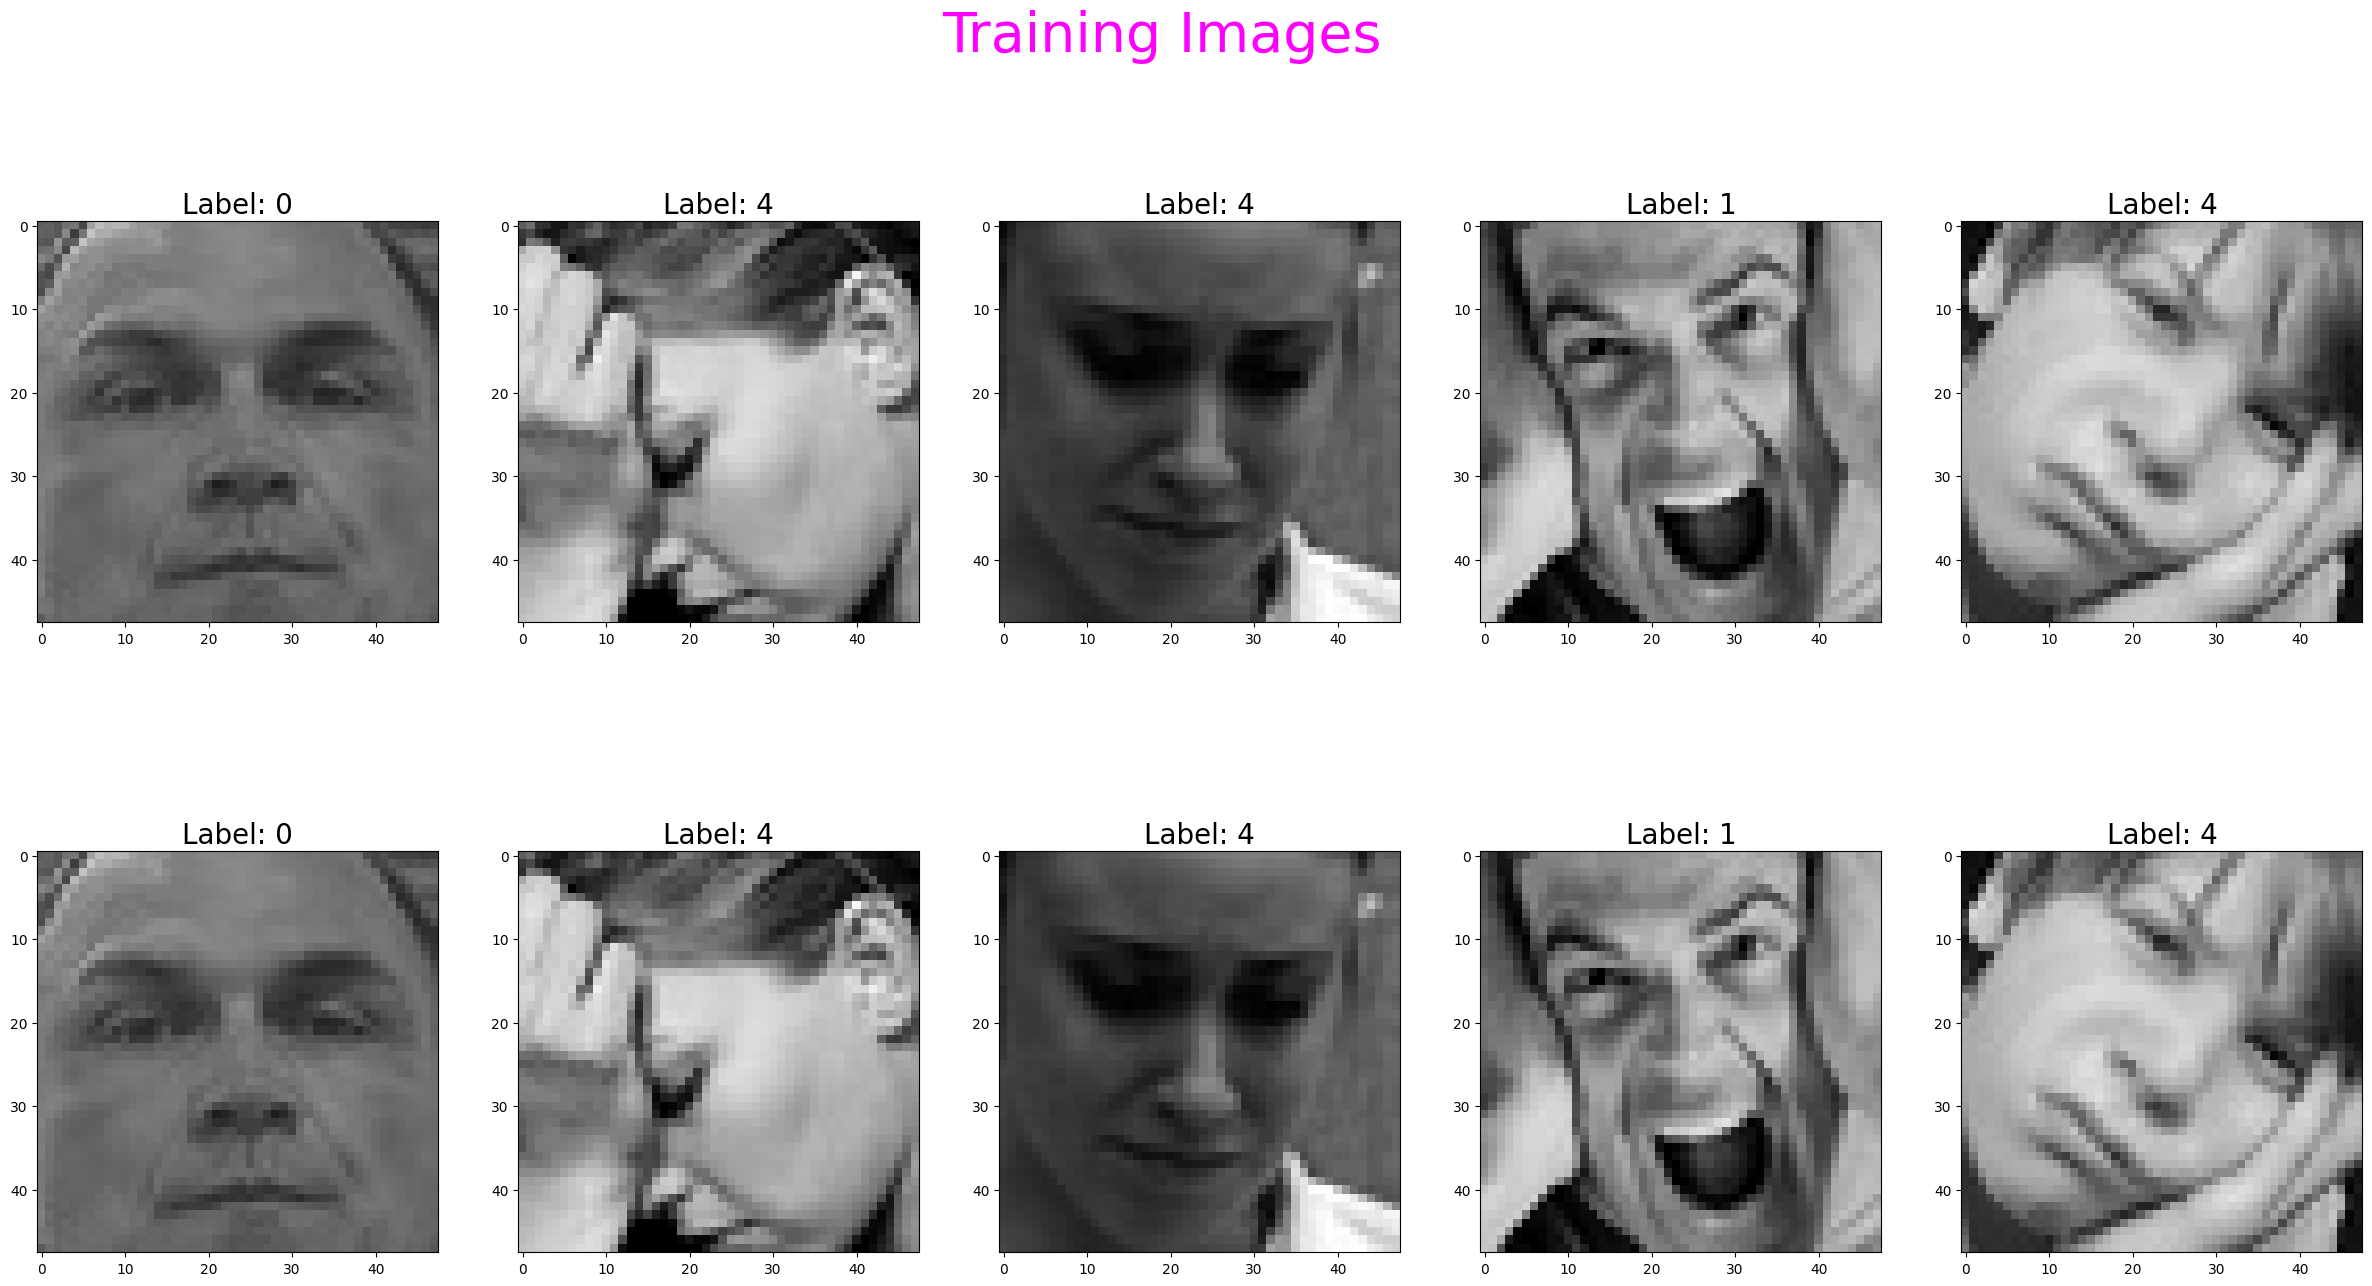

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 5, figsize=(30, 15))
fig.suptitle('Training Images', color='magenta', fontsize=40)

for i, (image_batch, label_batch) in enumerate(train_split.take(1)):
    for j in range(2):
        for k in range(5):
            ax[j, k].imshow(image_batch[k].numpy())
            ax[j, k].set_title(f'Label: {label_batch[k].numpy()}', fontsize=20)


## b) Model Architecture

###VGG 16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
IMAGE_SIZE = [48, 48, 3]
base_model = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

In [ ]:
base_model.trainable = False   #Freeze Base Layers
inputs = tf.keras.Input(shape=(48, 48, 3))

In [ ]:
# Load it again temporarily just to get class names
raw_train_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/facial-recognition-dataset/Training/Training",
    labels='inferred',
    shuffle=True,
    validation_split=0.2,
    subset="training",
    image_size=(48, 48),
    seed=11
)

num_classes = len(raw_train_dataset.class_names)
print("Number of classes:", num_classes)


Found 28273 files belonging to 6 classes.
Using 22619 files for training.
Number of classes: 6


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Number of classes
num_classes = len(raw_train_dataset.class_names)

# Define the model architecture
IMAGE_SIZE = [48, 48, 3]
base_model = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

base_model.trainable = False  # Freeze the base layers

inputs = tf.keras.Input(shape=(48, 48, 3))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Custom Classification Layers
outputs = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs, outputs)

# Show model summary
model.summary()

# Compile the model
from tensorflow.keras import optimizers

adam = optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',  # For integer labels
              optimizer=adam,
              metrics=['accuracy'])

# Train the model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

checkpoint = ModelCheckpoint(filepath='/content/vgg16_weights_tf_dim_ordering_tf_kernels.keras',
                               verbose=2, save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

model_history = model.fit(
                      train_split,
                      validation_data=test_split,
                      epochs=5,
                      callbacks=callbacks, verbose=2)

# Duration
duration = datetime.now() - start
print("Training completed in time: ", duration)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,766 (56.14 MB)

 Trainable params: 3,078 (12.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5

Epoch 1: val_loss improved from inf to 1.59045, saving model to /content/vgg16_weights_tf_dim_ordering_tf_kernels.keras
494/494 - 623s - 1s/step - accuracy: 0.3300 - loss: 1.6373 - val_accuracy: 0.3590 - val_loss: 1.5904
Epoch 2/5

Epoch 2: val_loss improved from 1.59045 to 1.54941, saving model to /content/vgg16_weights_tf_dim_ordering_tf_kernels.keras
494/494 - 630s - 1s/step - accuracy: 0.3816 - loss: 1.5519 - val_accuracy: 0.3785 - val_loss: 1.5494
Epoch 3/5

Epoch 3: val_loss improved from 1.54941 to 1.53151, saving model to /content/vgg16_weights_tf_dim_ordering_tf_kernels.keras
494/494 - 615s - 1s/step - accuracy: 0.4000 - loss: 1.5206 - val_accuracy: 0.3856 - val_loss: 1.5315
Epoch 4/5

Epoch 4: val_loss did not improve from 1.53151
494/494 - 623s - 1s/step - accuracy: 0.4123 - loss: 1.5012 - val_accuracy: 0.3842 - val_loss: 1.5350
Epoch 5/5

Epoch 5: val_loss improved from 1.53151 to 1.51888, saving model to /content/vgg16_weights_tf_dim_ordering_tf_kernels.keras
49

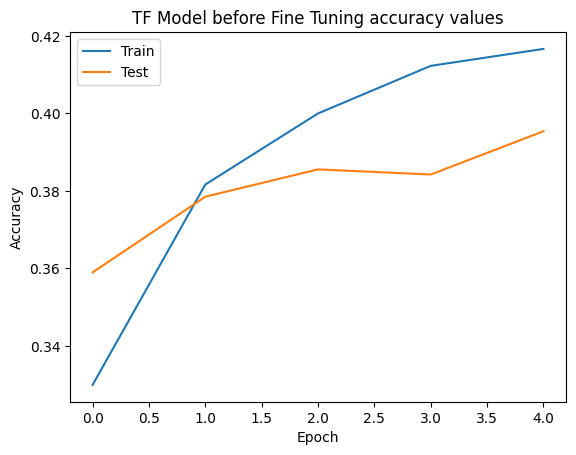

In [ ]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('TF Model before Fine Tuning accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

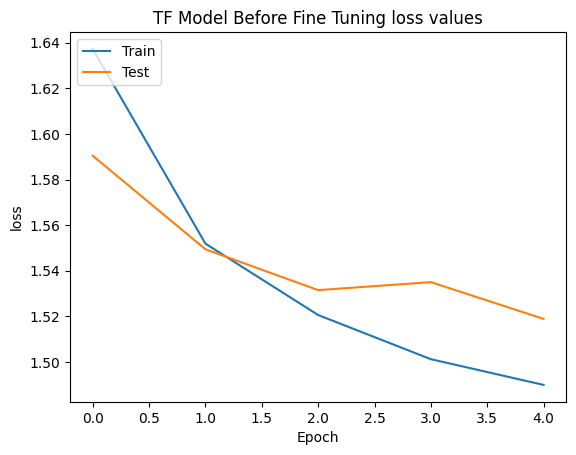

In [ ]:
# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('TF Model Before Fine Tuning loss values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

###ResNet

In [ ]:
from tensorflow.keras.applications import ResNet50


In [ ]:
num_classes = len(raw_train_dataset.class_names)

base_model = ResNet50(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
base_model.trainable = False  # Freeze the base model


In [ ]:
inputs = tf.keras.Input(shape=IMAGE_SIZE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Show model structure
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
adam = optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='/content/resnet50_best_weights.keras',
                             verbose=2, save_best_only=True)
callbacks = [checkpoint]

In [ ]:
start = datetime.now()
model_history = model.fit(
    train_split,
    validation_data=test_split,
    epochs=5,
    callbacks=callbacks,
    verbose=2
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/5

Epoch 1: val_loss improved from inf to 1.70938, saving model to /content/resnet50_best_weights.keras
494/494 - 238s - 482ms/step - accuracy: 0.2520 - loss: 1.7479 - val_accuracy: 0.2735 - val_loss: 1.7094
Epoch 2/5

Epoch 2: val_loss did not improve from 1.70938
494/494 - 227s - 459ms/step - accuracy: 0.2760 - loss: 1.7111 - val_accuracy: 0.2176 - val_loss: 1.7493
Epoch 3/5

Epoch 3: val_loss improved from 1.70938 to 1.70429, saving model to /content/resnet50_best_weights.keras
494/494 - 262s - 531ms/step - accuracy: 0.2914 - loss: 1.6955 - val_accuracy: 0.2975 - val_loss: 1.7043
Epoch 4/5

Epoch 4: val_loss improved from 1.70429 to 1.66212, saving model to /content/resnet50_best_weights.keras
494/494 - 260s - 526ms/step - accuracy: 0.3097 - loss: 1.6730 - val_accuracy: 0.3161 - val_loss: 1.6621
Epoch 5/5

Epoch 5: val_loss did not improve from 1.66212
494/494 - 224s - 454ms/step - accuracy: 0.3102 - loss: 1.6665 - val_accuracy: 0.3036 - val_loss: 1.6841
Training completed i

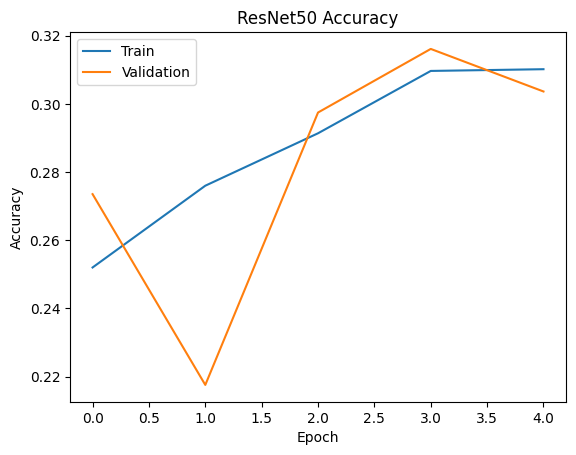

In [ ]:
# Plot training and validation accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('ResNet50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

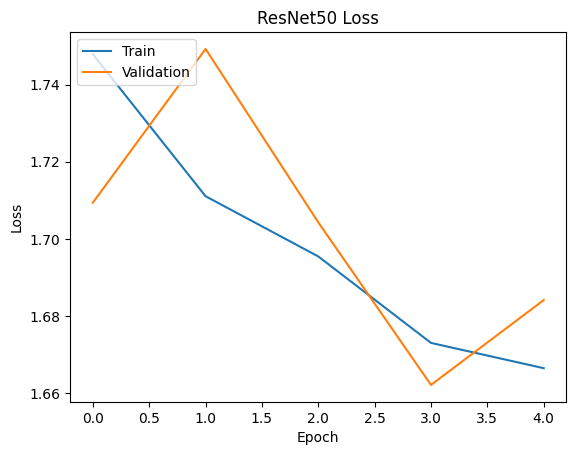

In [ ]:
# Plot training and validation loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('ResNet50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

###Evaluation

In [ ]:
vgg16_eval = model.evaluate(test_split, verbose=2)
print(f"\n VGG16 Test Accuracy: {vgg16_eval[1]*100:.2f}%")
print(f" VGG16 Test Loss: {vgg16_eval[0]:.4f}")

from tensorflow.keras.models import load_model
resnet_model = load_model('/content/resnet50_best_weights.keras')

resnet_eval = resnet_model.evaluate(test_split, verbose=2)
print(f"\n ResNet50 Test Accuracy: {resnet_eval[1]*100:.2f}%")
print(f" ResNet50 Test Loss: {resnet_eval[0]:.4f}")


213/213 - 71s - 335ms/step - accuracy: 0.3022 - loss: 1.6839

 VGG16 Test Accuracy: 30.22%
 VGG16 Test Loss: 1.6839
213/213 - 77s - 359ms/step - accuracy: 0.3164 - loss: 1.6609

 ResNet50 Test Accuracy: 31.64%
 ResNet50 Test Loss: 1.6609
